In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def add_project_root(project_name: str = "extrema_lab"):
    cwd = os.getcwd()
    path_parts = cwd.split(os.sep)

    for i in range(len(path_parts), 0, -1):
        potential_root = os.sep.join(path_parts[:i])
        if os.path.basename(potential_root) == project_name:
            root = os.path.dirname(potential_root)
            if root not in sys.path:
                sys.path.append(root)
            print(f"已添加项目根目录到 sys.path: {root}")
            return

    print(f"未找到项目 {project_name}，请确认路径是否正确")


add_project_root("extrema_lab")
from extrema_lab.feature_eng.operator.utils_tools import *

已添加项目根目录到 sys.path: C:\quant\work


In [2]:
symbol = "BTCUSDT"
threshold = 0.0031
feat_cal_window = 400
feat_norm_window = 400
feat_norm_rolling_mean_window = 200

origin_df = process_single_symbol(
    symbol,
    str(threshold),
    feat_cal_window,
    feat_norm_window,
    feat_norm_rolling_mean_window,
)


In [3]:
origin_df

timestamp,px,sum_buy_sz,sum_sell_sz,ts_duration,px_pct,bs_imbalance,oi_sum_open_interest,oi_sum_open_interest_value,funding_funding_interval_hours,funding_last_funding_rate,premium_open,adjusted_funding_rate,funding_oi,premium_oi,funding_premium,factor_triplet,premium_funding_spread,oi_sum_open_interest_value_roll_mean_ratio_12,oi_sum_open_interest_value_pct_change_sum_12,oi_sum_open_interest_value_roll_mean_ratio_72,oi_sum_open_interest_value_pct_change_sum_72,oi_sum_open_interest_value_roll_mean_ratio_144,oi_sum_open_interest_value_pct_change_sum_144,oi_sum_open_interest_value_roll_mean_ratio_288,oi_sum_open_interest_value_pct_change_sum_288,premium_funding_spread_sum_288,adjusted_funding_rate_sum_288,premium_open_sum_288,funding_oi_roll_mean_ratio_288,premium_oi_roll_mean_ratio_288,factor_triplet_roll_mean_ratio_288,premium_oi_dev_144,z_oi_sum_open_interest,z_oi_sum_open_interest_value,z_funding_oi,z_premium_oi,…,z_oi_dn_divergence_short_term_zscaled,z_sum_sz_px_pct_rol_sum_400_zscaled,z_px_velo_rol_mean_400_zscaled,z_oi_px_diff_400_zscaled,oi_di_zscaled,oi_di_long_term_zscaled,oi_di_short_term_zscaled,taker_px_pct_diff_zscaled,factor_impact_momentum_zscaled,factor_impact_sensitivity_zscaled,factor_orderflow_sz_momentum_zscaled,factor_orderflow_sz_sensitivity_zscaled,z_oi_di_zscaled,z_oi_di_long_term_zscaled,z_taker_px_pct_diff_zscaled,z_factor_impact_momentum_zscaled,z_factor_impact_sensitivity_zscaled,z_factor_orderflow_sz_momentum_zscaled,z_factor_orderflow_sz_sensitivity_zscaled,factor_order_momentum_divergence_zscaled,factor_order_sentiment_divergence_zscaled,corr_px_oi_sum_open_interest_value_400_zscaled,z_signal_px_oi_sum_open_interest_value_400_zscaled,z_factor_order_momentum_divergence_zscaled,z_factor_order_sentiment_divergence_zscaled,z_corr_px_oi_sum_open_interest_value_400_zscaled,z_px_oi_corr_activation_zscaled,px_risk_factor_zscaled,px_drawdown_zscaled,px_rebound_zscaled,z_px_risk_factor_zscaled,z_px_drawdown_zscaled,z_px_rebound_zscaled,px_dd_rb_zscaled,micro_trend_factor_400_zscaled,z_px_dd_rb_zscaled,z_micro_trend_factor_400_zscaled
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1727742383036000,63308.2,1619.597,2038.661,6.56649e8,0.003101,-419.064,1.3168709e7,20888.057902,8.0,0.0001,-0.000452,0.0000125,0.261101,-9.434718,-5.6460e-9,-0.000118,-0.000464,1.002693,0.0072,1.006444,0.001663,1.004434,-0.004474,1.00263,0.004391,-0.133684,0.0036,-0.130084,1.00263,1.00263,1.00263,0.004434,-1.257775,0.676151,0.676145,-0.676151,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1727743847028000,63504.7,1736.046,1404.307,1.4640e9,0.003104,331.739,1.3177476e7,20794.305246,8.0,0.0001,-0.000452,0.0000125,0.259929,-9.392372,-5.6460e-9,-0.000117,-0.000464,0.998231,-0.003449,1.001896,0.001577,1.000208,-0.010651,0.998148,-0.002069,-0.133684,0.0036,-0.130084,0.998148,0.998148,0.998148,0.000208,-1.16837,-0.475815,-0.47581,0.475815,…,-0.30443,0.30443,0.30443,-0.30443,-0.30443,0.303941,0.304136,0.30443,0.30443,0.30443,-0.30443,-0.30443,-0.30443,0.30443,0.30443,0.30443,0.30443,-0.30443,-0.30443,0.304407,0.30443,-0.30443,0.0,0.30443,0.30443,-0.30443,0.30443,0.30443,0.0,0.30443,0.30443,0.0,0.30443,0.30443,0.0,0.30443,0.0
1727748396831000,63307.8,3556.816,5470.646,4.5498e9,-0.003101,-1913.83,1.3153528e7,20742.963477,8.0,0.0001,-0.000452,0.0000125,0.259287,-9.369182,-5.6460e-9,-0.000117,-0.000464,1.001691,0.000167,0.999951,-0.000584,0.998451,-0.006403,0.995955,-0.002922,-0.133684,0.0036,-0.130084,0.995955,0.995955,0.995955,-0.001549,-1.302884,-0.991327,-0.991318,0.991327,…,-0.443075,-0.064761,-0.064658,-0.36473,-0.437254,0.029887,0.029832,-0.068452,-0.065236,-0.064106,-0.25084,-0.038931,-0.

In [4]:
prices_np = origin_df["px"].to_numpy()[:20000]
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02) 
avg_steps_5pct = avg_steps_to_volatility(prices_np, 0.05) 

print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
print("波动 ±1% 的均值步数:", avg_steps_1pct)
print("波动 ±2% 的均值步数:", avg_steps_2pct)

origin_df = origin_df.with_columns([
    future_return_expr("px", avg_steps_05pct),
    future_return_expr("px", avg_steps_1pct),
    future_return_expr("px", avg_steps_2pct),
])
print(origin_df)
origin_df = clean_df_drop_nulls(origin_df)

cal abs change 5.00% avg steps: 100%|████████████████████████████████████████████████████████████████████| 19678/19678 [00:00<00:00, 21174.73it/s]


波动 ±0.5% 的均值步数: 3
波动 ±1% 的均值步数: 14
波动 ±2% 的均值步数: 43
shape: (19_678, 272)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬────────────────────────────┬─────────────────┬──────────────────┬──────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_micro_trend_factor_400_z ┆ future_return_3 ┆ future_return_14 ┆ future_return_43 │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ scal…                      ┆ ---             ┆ ---              ┆ ---              │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                        ┆ f64             ┆ f64              ┆ f64              │
│                  ┆          ┆            ┆             ┆   ┆ f64                        ┆                 ┆                  ┆                  │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪════════════════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ 1727742383036000 ┆ 63308.2  ┆ 1619.59

In [5]:
origin_df_secs = origin_df.with_columns(
    (pl.col("ts_duration") / 1_000_000).alias("ts_duration_secs")
)

origin_df_secs.select("ts_duration_secs").describe()

statistic,ts_duration_secs
str,f64
"""count""",19678.0
"""null_count""",0.0
"""mean""",1268.461293
"""std""",2497.989813
"""min""",1.001
"""25%""",134.623
"""50%""",429.333
"""75%""",1304.204
"""max""",55675.554


In [6]:
exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_2pct}"
print(origin_df)

shape: (19_678, 272)
┌───────────┬──────────┬────────────┬─────────────┬───┬─────────────────────────────────┬─────────────────┬──────────────────┬──────────────────┐
│ timestamp ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_micro_trend_factor_400_zscal… ┆ future_return_3 ┆ future_return_14 ┆ future_return_43 │
│ ---       ┆ ---      ┆ ---        ┆ ---         ┆   ┆ ---                             ┆ ---             ┆ ---              ┆ ---              │
│ f64       ┆ f64      ┆ f64        ┆ f64         ┆   ┆ f64                             ┆ f64             ┆ f64              ┆ f64              │
╞═══════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════════════════╪═════════════════╪══════════════════╪══════════════════╡
│ 1.7277e15 ┆ 63308.2  ┆ 1619.597   ┆ 2038.661    ┆ … ┆ 0.0                             ┆ 0.003094        ┆ -0.01239         ┆ -0.021675        │
│ 1.7277e15 ┆ 63504.7  ┆ 1736.046   ┆ 1404.307    ┆ … ┆ 0.0                             ┆ 0.003091     

In [7]:
from scipy.stats import spearmanr

df = origin_df.to_pandas()

ic_list = []

for col in df.columns:
    if "scaled" in col:
        ic = spearmanr(df[col], df[target_col], nan_policy='omit')[0]
        ic_list.append((col, ic))

# 按照 IC 从大到小排序并输出
sorted_ic = sorted(ic_list, key=lambda x: abs(x[1]), reverse=True)

for col, ic in sorted_ic:
    print(f"{col:<30} IC: {ic:.4f}")


z_signal_px_oi_sum_open_interest_value_400_zscaled IC: 0.0836
log1p_ts_velo_rol_mean_400_rsi_400_zscaled IC: 0.0751
px_rebound_zscaled             IC: -0.0738
factor_orderflow_sz_momentum_zscaled IC: -0.0730
factor_orderflow_sz_sensitivity_zscaled IC: -0.0729
z_oi_di_zscaled                IC: -0.0695
z_px_rebound_zscaled           IC: -0.0661
oi_di_zscaled                  IC: -0.0651
corr_px_oi_sum_open_interest_value_400_zscaled IC: 0.0607
factor_impact_sensitivity_zscaled IC: -0.0590
z_factor_orderflow_sz_sensitivity_zscaled IC: -0.0589
z_px_velo_rol_mean_400_zscaled IC: -0.0579
z_px_pct_rol_sum_400_zscaled   IC: -0.0566
z_factor_impact_sensitivity_zscaled IC: -0.0557
z_factor_impact_momentum_zscaled IC: -0.0550
factor_impact_momentum_zscaled IC: -0.0547
z_log1p_ts_velo_rol_mean_400_rsi_400_zscaled IC: 0.0543
z_sum_sz_px_pct_rol_sum_400_zscaled IC: -0.0543
z_log1p_sum_sz_400_rsi_400_zscaled IC: 0.0528
log1p_sum_sz_400_rsi_400_zscaled IC: 0.0487
z_factor_order_momentum_divergence_zs

C:\Users\Grayman\AppData\Local\Temp\ipykernel_51808\696301604.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(df[col], df[target_col], nan_policy='omit')[0]


In [8]:
ic_df = rolling_ic_ir_icto_index(
    origin_df,
    target_col=target_col,
    window_size=1000,
    step=100,
)
print(ic_df)

Rolling IC & ICTO: 100%|████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:02<00:00, 62.53it/s]

shape: (133, 6)
┌─────────────────────────────────┬────────────┬────────────┬───────────────┬───────────┬────────────┐
│ factor                          ┆ mean_ic    ┆ std_ic     ┆ mean_turnover ┆ ir        ┆ icto       │
│ ---                             ┆ ---        ┆ ---        ┆ ---           ┆ ---       ┆ ---        │
│ str                             ┆ f64        ┆ f64        ┆ f64           ┆ f64       ┆ f64        │
╞═════════════════════════════════╪════════════╪════════════╪═══════════════╪═══════════╪════════════╡
│ premium_funding_spread_sum_288… ┆ -0.00413   ┆ 0.02746    ┆ 0.001899      ┆ -0.15041  ┆ 2.174485   │
│ premium_open_sum_288_zscaled    ┆ 0.003444   ┆ 0.025208   ┆ 0.002375      ┆ 0.136642  ┆ 1.4501     │
│ funding_premium_zscaled         ┆ -0.00375   ┆ 0.041747   ┆ 0.003167      ┆ -0.08983  ┆ 1.184105   │
│ adjusted_funding_rate_zscaled   ┆ 0.002715   ┆ 0.024141   ┆ 0.003225      ┆ 0.112461  ┆ 0.841724   │
│ funding_last_funding_rate_zsca… ┆ 0.002715   ┆ 0.024141

In [9]:
adf = ic_df.to_pandas().dropna()
adf


,factor,mean_ic,std_ic,mean_turnover,ir,icto
0,premium_funding_spread_sum_288_zscaled,-4.130281e-03,2.746022e-02,0.001899,-0.150410,2.174485e+00
1,premium_open_sum_288_zscaled,3.444477e-03,2.520798e-02,0.002375,0.136642,1.450100e+00
2,funding_premium_zscaled,-3.750144e-03,4.174721e-02,0.003167,-0.089830,1.184105e+00
3,adjusted_funding_rate_zscaled,2.714935e-03,2.414103e-02,0.003225,0.112461,8.417241e-01
4,funding_last_funding_rate_zscaled,2.714935e-03,2.414103e-02,0.003225,0.112461,8.417241e-01
...,...,...,...,...,...,...
128,log1p_sum_sz_400_zscaled,-4.626191e-03,1.971502e-01,0.240574,-0.023465,1.922979e-02
129,z_px_risk_factor_zscaled,-2.708414e-03,2.075056e-01,0.253081,-0.013052,1.070178e-02
130,micro_trend_factor_400_zscaled,-2.221569e-03,2.247708e-01,0.277721,-0.009884,7.999278e-03
131,z_premium_open_sum_288_zscaled,1.748663e-18,6.338973e-17,0.000000,0.027586,1.748663e-10


In [10]:
print(ic_df.sort("mean_ic"))

shape: (133, 6)
┌─────────────────────────────────┬───────────┬──────────┬───────────────┬───────────┬──────────┐
│ factor                          ┆ mean_ic   ┆ std_ic   ┆ mean_turnover ┆ ir        ┆ icto     │
│ ---                             ┆ ---       ┆ ---      ┆ ---           ┆ ---       ┆ ---      │
│ str                             ┆ f64       ┆ f64      ┆ f64           ┆ f64       ┆ f64      │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════════╪═══════════╪══════════╡
│ px_rebound_zscaled              ┆ -0.136747 ┆ 0.163531 ┆ 0.238181      ┆ -0.836212 ┆ 0.574129 │
│ px_max_400_zscaled              ┆ -0.11597  ┆ 0.183991 ┆ 0.210682      ┆ -0.630302 ┆ 0.550449 │
│ px_pct_rol_sum_400_zscaled      ┆ -0.115531 ┆ 0.174811 ┆ 0.222153      ┆ -0.660889 ┆ 0.520051 │
│ px_velo_rol_mean_400_zscaled    ┆ -0.11269  ┆ 0.173839 ┆ 0.221243      ┆ -0.648244 ┆ 0.509349 │
│ sum_sz_px_pct_rol_sum_400_zsca… ┆ -0.11051  ┆ 0.17517  ┆ 0.221194      ┆ -0.630871 ┆ 0.499605 │
│ … 

In [11]:
selected_factors = adf["factor"].to_list()
print(selected_factors[:20])

['premium_funding_spread_sum_288_zscaled', 'premium_open_sum_288_zscaled', 'funding_premium_zscaled', 'adjusted_funding_rate_zscaled', 'funding_last_funding_rate_zscaled', 'px_rebound_zscaled', 'px_max_400_zscaled', 'px_pct_rol_sum_400_zscaled', 'px_velo_rol_mean_400_zscaled', 'sum_sz_px_pct_rol_sum_400_zscaled', 'oi_up_divergence_zscaled', 'log1p_sum_open_interest_value_zscaled', 'funding_oi_zscaled', 'premium_oi_zscaled', 'oi_sum_open_interest_value_zscaled', 'factor_triplet_zscaled', 'oi_up_divergence_short_term_zscaled', 'z_signal_px_oi_sum_open_interest_value_400_zscaled', 'oi_di_short_term_zscaled', 'oi_di_long_term_zscaled']


In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def calc_hourly_ic_df_pd(
        df: pd.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        bar_per_hour: int,
) -> pd.DataFrame:
    # 选出有效因子列
    feature_cols = [
        col for col in df.columns
        if col.endswith("_zscaled") 
           # and (col.startswith("z_") or col.startswith("raw_"))
           and not any(col.startswith(prefix) for prefix in exclude_prefixes)
           and not col.startswith("future_return_")
           and col != "px"
    ]

    n = len(df)
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - bar_per_hour + 1, bar_per_hour), desc="Hourly IC Calc"):
        end = start + bar_per_hour
        df_win = df.iloc[start:end].copy()

        # 排序转换为rank并归一化
        df_ranked = df_win[feature_cols + [target_col]].rank(method="average") / bar_per_hour
        target_rank_col = target_col

        for feat in feature_cols:
            ic = df_ranked[[feat, target_rank_col]].corr().iloc[0, 1]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            prev_ranks[feat] = df_ranked[feat].to_numpy()

            results.append({
                "hour_index": start // bar_per_hour,
                "factor": feat,
                "ic": ic if not np.isnan(ic) else None,
                "turnover": turnover if turnover is not None else None
            })

    return pd.DataFrame(results)


In [13]:
hourly_ic_df = calc_hourly_ic_df_pd(origin_df.to_pandas(), target_col, [], bar_per_hour=60)


Hourly IC Calc: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:10<00:00, 32.10it/s]


In [14]:
hourly_ic_df

,hour_index,factor,ic,turnover
0,0,sum_buy_sz_zscaled,-0.576493,NaN
1,0,sum_sell_sz_zscaled,-0.436232,NaN
2,0,ts_duration_zscaled,-0.536593,NaN
3,0,px_pct_zscaled,-0.383495,NaN
4,0,bs_imbalance_zscaled,-0.271575,NaN
...,...,...,...,...
43486,326,z_px_rebound_zscaled,-0.336427,0.000000
43487,326,px_dd_rb_zscaled,0.335593,0.094444
43488,326,micro_trend_factor_400_zscaled,0.336427,0.446111
43489,326,z_px_dd_rb_zscaled,0.370270,0.255556


In [15]:
target_factor = "px_rebound_zscaled"
ic_df.filter(pl.col("factor") == target_factor)

factor,mean_ic,std_ic,mean_turnover,ir,icto
str,f64,f64,f64,f64,f64
"""px_rebound_zscaled""",-0.136747,0.163531,0.238181,-0.836212,0.574129


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ic_summary(df, top_k: int = 10):
    summary = (
        df.groupby("factor")
        .agg(mean_ic=("ic", "mean"), std_ic=("ic", "std"), mean_turnover=("turnover", "mean"))
        .reset_index()
    )
    summary["ir"] = summary["mean_ic"] / (summary["std_ic"] + 1e-6)
    summary["icto"] = summary["mean_ic"].abs() / (summary["mean_turnover"] + 1e-6)

    for metric in ["mean_ic", "ir", "icto"]:
        top_factors = summary.nlargest(top_k, metric)
        print(top_factors)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=metric, y="factor", data=top_factors, palette="viridis")
        plt.title(f"Top {top_k} Factors by {metric}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_factor_ic_timeseries(df, factor_name: str):
    df_factor = df[df["factor"] == factor_name].copy()
    if df_factor.empty:
        print(f"[!] 因子 '{factor_name}' 不存在于数据中。")
        return

    # 排序 + 去掉 NaN
    df_factor = df_factor.sort_values("hour_index")
    df_factor = df_factor[df_factor["ic"].notna() & df_factor["ic"].apply(np.isfinite)]

    # 画图
    plt.figure(figsize=(12, 4))
    plt.plot(df_factor["hour_index"], df_factor["ic"], label=factor_name, color="blue")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Hourly IC of Factor: {factor_name}")
    plt.xlabel("Hour Index")
    plt.ylabel("Information Coefficient (IC)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def plot_factor_rankings(df, top_n: int = 15, by: str = "icto"):
    """
    by: 'mean_ic' | 'ir' | 'icto'
    """
    df_sorted = df.sort_values(by, ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_sorted, y="factor", x=by, palette="viridis")
    plt.title(f"Top {top_n} Factors by {by}")
    plt.xlabel(by.upper())
    plt.ylabel("Factor")
    plt.tight_layout()
    plt.show()

def plot_ic_vs_turnover(df):
    plt.figure(figsize=(8, 6))
    plt.scatter(df["mean_turnover"], df["mean_ic"], alpha=0.7)
    for i, row in df.iterrows():
        if abs(row["mean_ic"]) > 0.1:  # 可自定义标注阈值
            plt.text(row["mean_turnover"], row["mean_ic"], row["factor"], fontsize=8)

    plt.xlabel("Mean Turnover")
    plt.ylabel("Mean IC")
    plt.title("IC vs Turnover")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_ic_vs_ir(df):
    plt.figure(figsize=(8, 6))
    plt.scatter(df["ir"], df["mean_ic"], c=df["icto"], cmap='coolwarm', alpha=0.8)
    plt.colorbar(label="ICTO")
    for i, row in df.iterrows():
        if row["icto"] > 2:  # 高效因子才标注
            plt.text(row["ir"], row["mean_ic"], row["factor"], fontsize=7)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.axvline(1, color='green', linestyle='--', linewidth=1)
    plt.xlabel("IR (Information Ratio)")
    plt.ylabel("Mean IC")
    plt.title("Factor Scatter: IR vs Mean IC")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_cumulative_ic(df, factor_name: str):

    # 过滤出指定因子，按时间排序
    df_factor = df[df["factor"] == factor_name].copy()
    if df_factor.empty:
        print(f"[!] 因子 '{factor_name}' 不存在于数据中。")
        return

    df_factor = df_factor.sort_values("hour_index")
    df_factor = df_factor[df_factor["ic"].notna() & df_factor["ic"].apply(np.isfinite)]
    
    # 计算累计 IC（可以累加，也可以累积平均）
    df_factor["cum_ic"] = df_factor["ic"].cumsum()
    print(df_factor["cum_ic"])
    df_factor["cum_to"] = df_factor["turnover"].cumsum()
    df_factor["x"] = df_factor["cum_ic"] / df_factor["cum_to"]

    # 画图
    plt.figure(figsize=(12, 4))
    plt.plot(df_factor["hour_index"], df_factor["cum_ic"], color="darkgreen", label="Cumulative IC")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f"Cumulative IC of Factor: {factor_name}")
    plt.xlabel("Hour Index")
    plt.ylabel("Cumulative IC")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

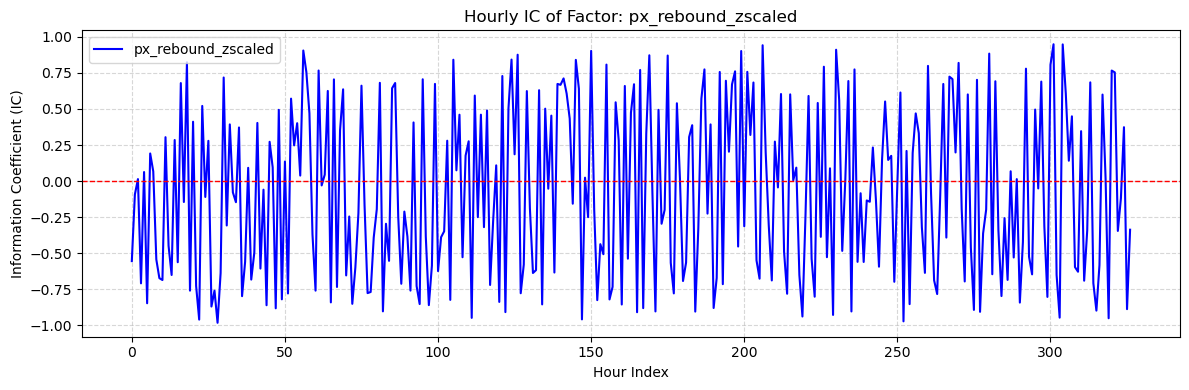

In [17]:
plot_factor_ic_timeseries(hourly_ic_df, factor_name=target_factor)


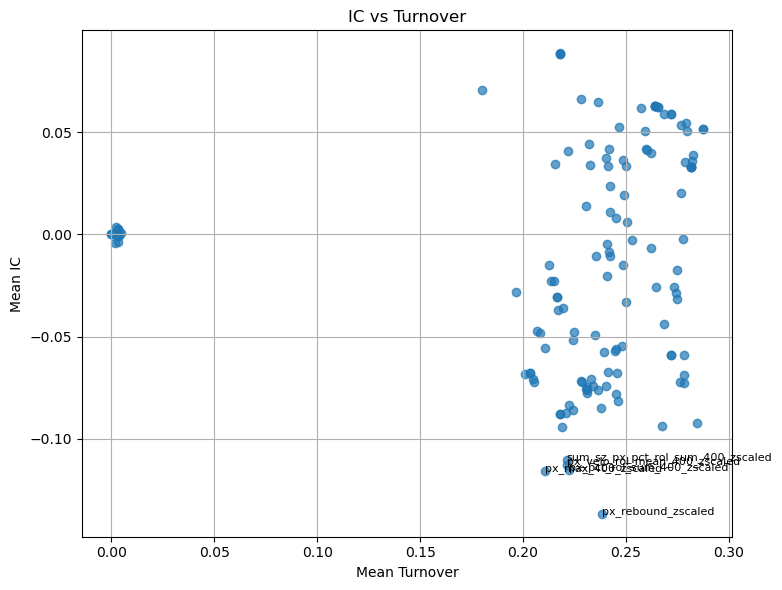

In [18]:
plot_ic_vs_turnover(ic_df.to_pandas())

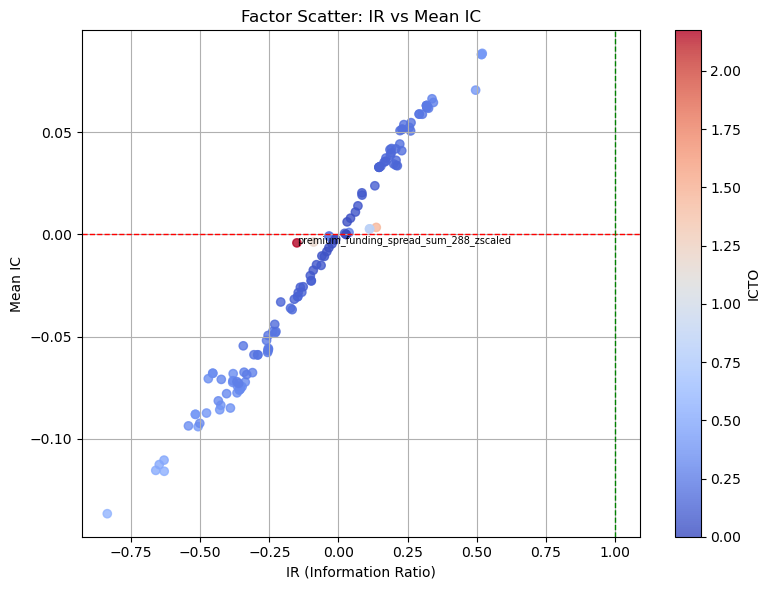

In [19]:
plot_ic_vs_ir(ic_df.to_pandas())

125      -0.553932
258      -0.645957
391      -0.631787
524      -1.339761
657      -1.276577
           ...    
42951   -22.865018
43084   -22.984607
43217   -22.610781
43350   -23.497527
43483   -23.833954
Name: cum_ic, Length: 327, dtype: float64


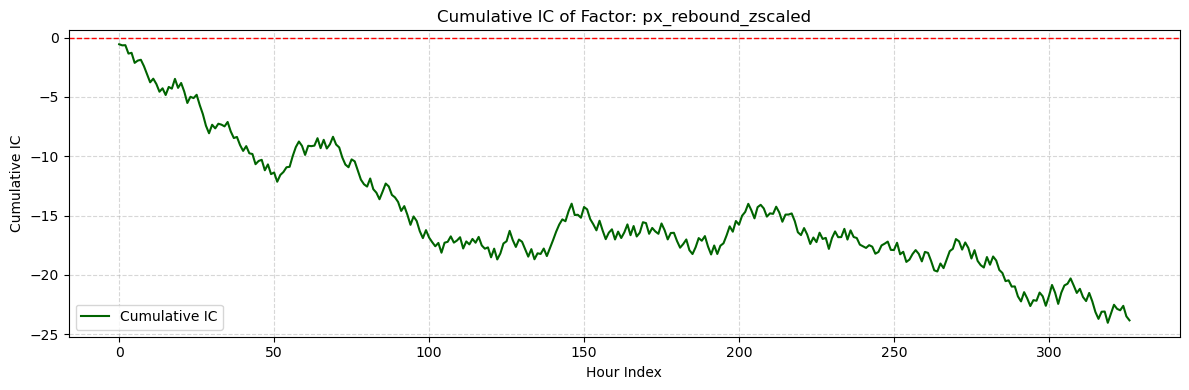

In [20]:
plot_cumulative_ic(hourly_ic_df, factor_name=target_factor)

每组平均收益：
 bin
0     0.003863
1     0.007011
2     0.007291
3     0.004343
4    -0.000402
5     0.001459
6    -0.001890
7     0.000674
8    -0.000560
9     0.000110
10    0.003088
11   -0.002267
12   -0.001355
13    0.000051
14    0.002235
Name: future_return_43, dtype: float64
多空组合收益： -0.0016280850068242127


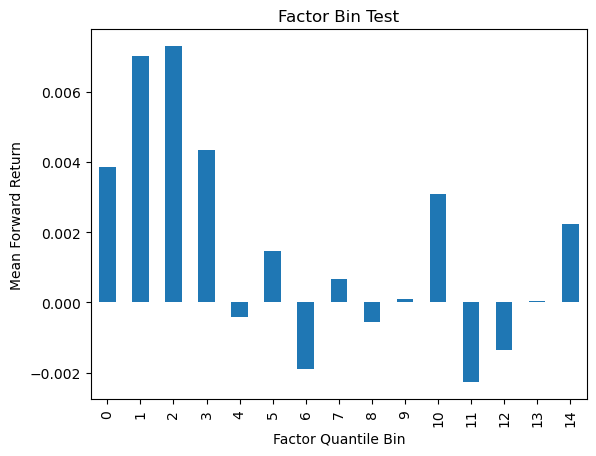

In [21]:
import pandas as pd

def factor_bin_backtest(df, factor_col="factor", ret_col="fwd_ret", n_bins=5):
    """
    分组bin回测
    """
    df = df.copy()
    
    # 按因子值分组
    df["bin"] = pd.qcut(df[factor_col], q=n_bins, labels=False)  # 分位数分箱
    
    # 计算每组收益
    grouped = df.groupby("bin")[ret_col].mean()
    
    # 多空组合收益（最高组 - 最低组）
    long_short = grouped.iloc[-1] - grouped.iloc[0]
    
    return grouped, long_short


# 示例
# 假设 df 里已经有因子值和未来收益
grouped_ret, ls_ret = factor_bin_backtest(origin_df.to_pandas(), target_factor, target_col, n_bins=15)

print("每组平均收益：\n", grouped_ret)
print("多空组合收益：", ls_ret)
import matplotlib.pyplot as plt

grouped_ret.plot(kind="bar")
plt.title("Factor Bin Test")
plt.xlabel("Factor Quantile Bin")
plt.ylabel("Mean Forward Return")
plt.show()


shape: (5, 273)
┌───────────┬─────────┬────────────┬─────────────┬───┬─────────────────┬──────────────────┬──────────────────┬─────────────┐
│ timestamp ┆ px      ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ future_return_3 ┆ future_return_14 ┆ future_return_43 ┆ factor_mean │
│ ---       ┆ ---     ┆ ---        ┆ ---         ┆   ┆ ---             ┆ ---              ┆ ---              ┆ ---         │
│ f64       ┆ f64     ┆ f64        ┆ f64         ┆   ┆ f64             ┆ f64              ┆ f64              ┆ f64         │
╞═══════════╪═════════╪════════════╪═════════════╪═══╪═════════════════╪══════════════════╪══════════════════╪═════════════╡
│ 1.7277e15 ┆ 63308.2 ┆ 1619.597   ┆ 2038.661    ┆ … ┆ 0.003094        ┆ -0.01239         ┆ -0.021675        ┆ 0.0         │
│ 1.7277e15 ┆ 63504.7 ┆ 1736.046   ┆ 1404.307    ┆ … ┆ 0.003091        ┆ -0.012393        ┆ -0.021676        ┆ 0.030443    │
│ 1.7277e15 ┆ 63307.8 ┆ 3556.816   ┆ 5470.646    ┆ … ┆ 0.009331        ┆ -0.012395        ┆ -0.01559         

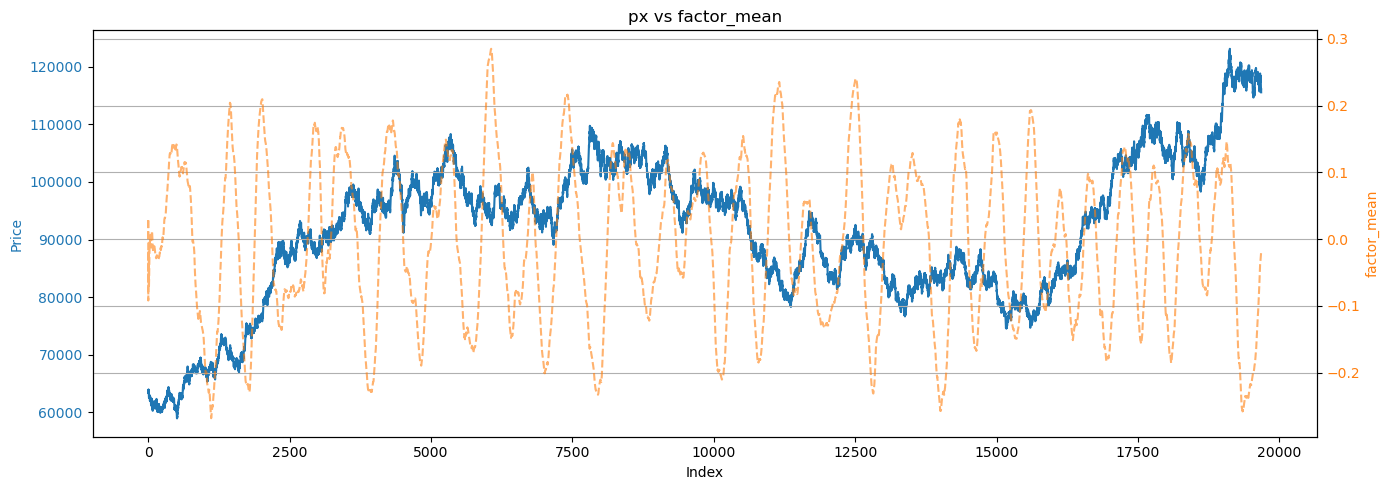

In [22]:
import polars as pl
import matplotlib.pyplot as plt

def plot_price_and_factor_mean(
    df: pl.DataFrame,
    price_col: str,
    factor_mean_col: str,
    n: int = 300
):
    # 先选择需要的列，取最后n条，转成pandas
    df_plot = df.select([price_col, factor_mean_col]).head(n).to_pandas()

    fig, ax1 = plt.subplots(figsize=(14, 5))
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Price", color="tab:blue")
    ax1.plot(df_plot[price_col], color="tab:blue", label="Price")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel(factor_mean_col, color="tab:orange")
    ax2.plot(df_plot[factor_mean_col], color="tab:orange", linestyle="--", alpha=0.6, label="Factor Mean")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    plt.title(f"{price_col} vs {factor_mean_col}")
    fig.tight_layout()
    plt.grid(True)
    plt.show()


exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
co = [
    col for col in origin_df.columns
    if (col.endswith("_zscaled") and col.startswith("z_"))
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
plot_df = origin_df.with_columns(
    pl.mean_horizontal(co).alias("factor_mean")
)

# 确认数据
print(plot_df.head())

# 调用绘图函数，传入含有 px 和 factor_mean 的 DataFrame
plot_price_and_factor_mean(
    df=plot_df,
    price_col="px",            # 你要画的价格列
    factor_mean_col="factor_mean",
    n=1000000
)


[固定阈值] upper=0.0596, lower=-0.0673

=== Strategy Summary (TREND) | Rolling: False ===
Total Trades      : 50
Winning Rate      : 36.00%
Strategy Return   : -58.12%
Benchmark Return  : 82.58%
Max Drawdown      : -66.41% at index 18813
Long Trades       : 25
Short Trades      : 26


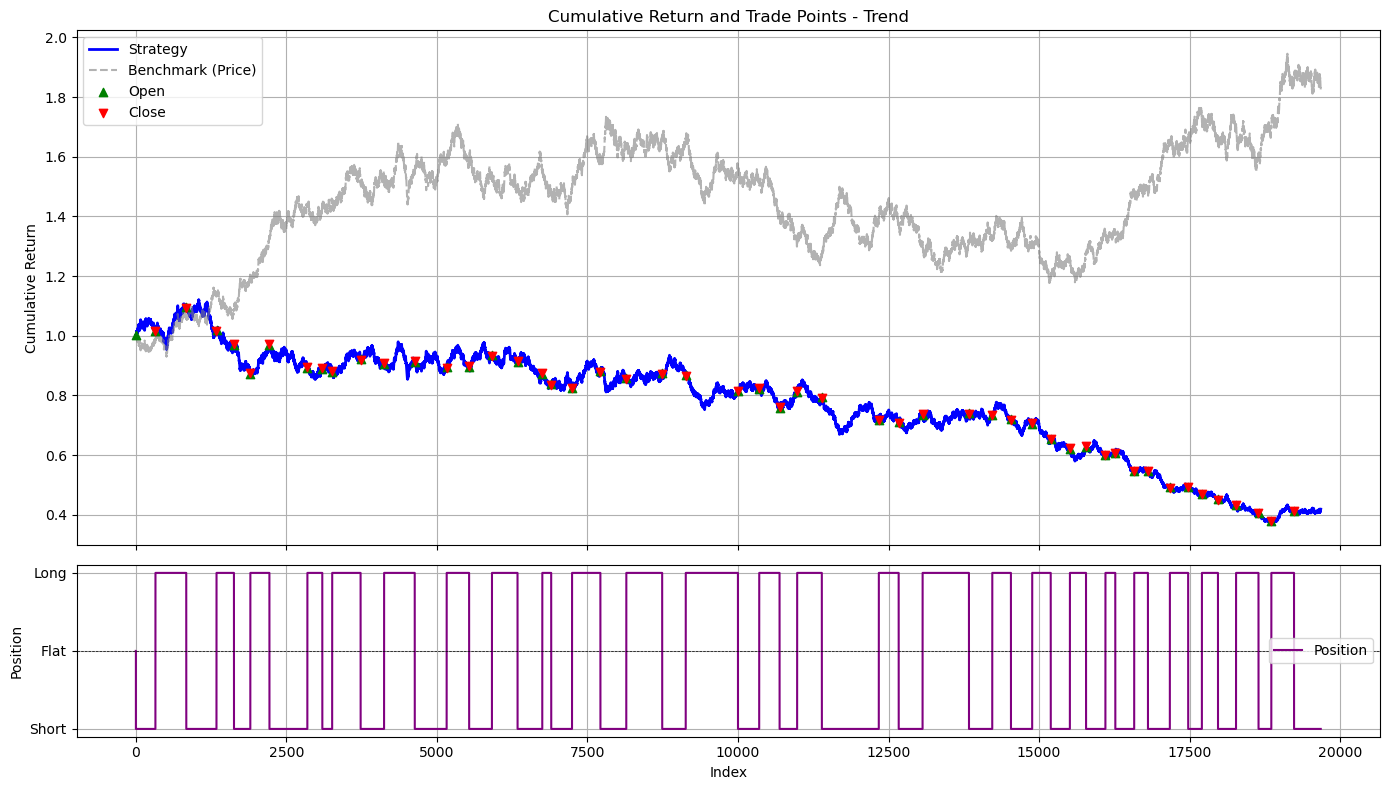

[固定阈值] upper=0.0596, lower=-0.0673

=== Strategy Summary (MEAN_REVERSION) | Rolling: False ===
Total Trades      : 50
Winning Rate      : 64.00%
Strategy Return   : 97.48%
Benchmark Return  : 82.58%
Max Drawdown      : -16.04% at index 14289
Long Trades       : 26
Short Trades      : 25


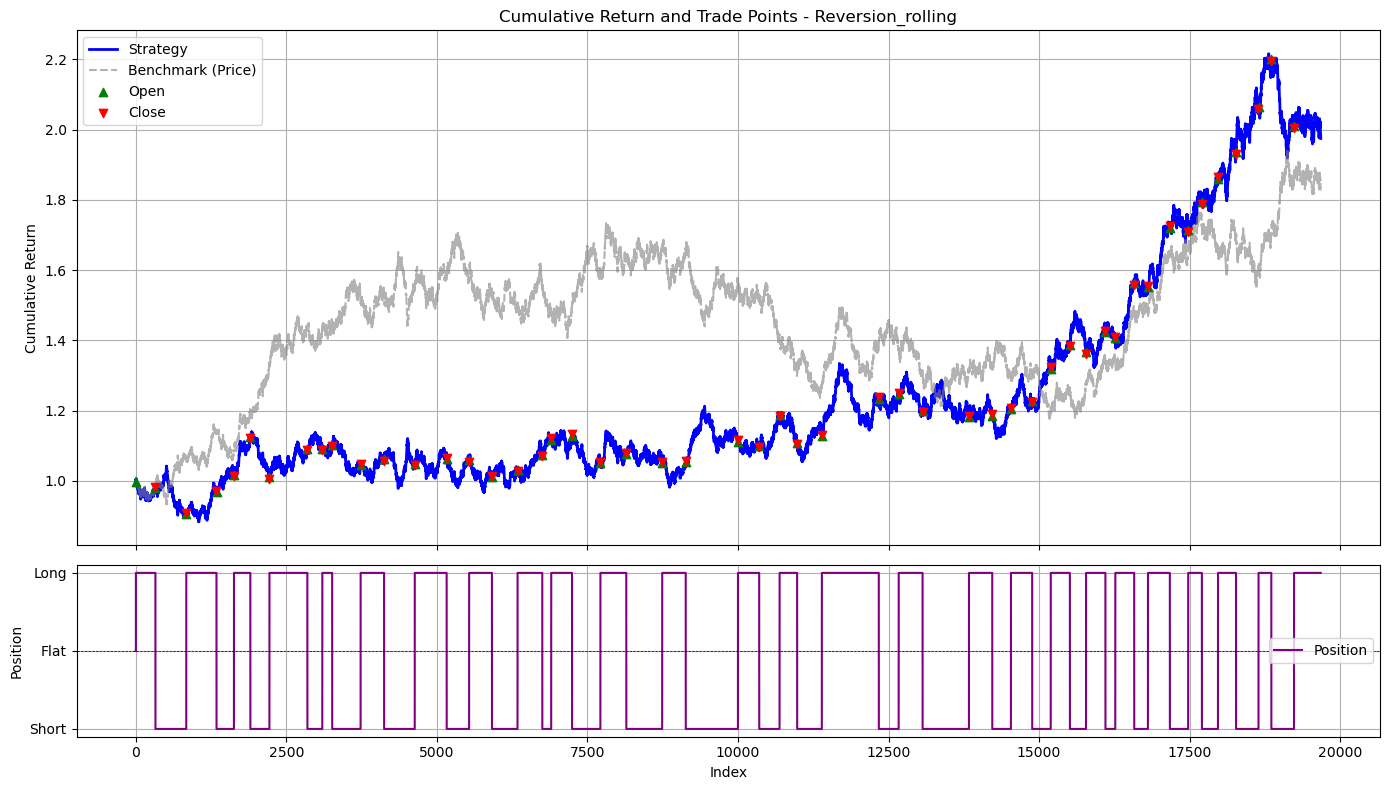

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.65,
    lower_q: float = 0.35,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower
        print(f"[固定阈值] upper={upper:.4f}, lower={lower:.4f}")


    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === 仓位逻辑 & 收益计算略，保持不变 ===
    # 以下部分和你原来的逻辑一致（略去重复部分）

    # 仓位计算
    position = [0]
    trades = []  # (idx, open/close, dir)

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if signal != 0 and np.sign(signal) != np.sign(prev_pos):
                position.append(0)
                trades.append((i, "close", prev_pos))
            else:
                position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # 胜率统计
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0

    # 最大回撤
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 策略和benchmark累计收益
    ax1.plot(df["cum_strategy"], label="Strategy", linewidth=2, color="blue")
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # 开仓/平仓点
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # 仓位图
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


df_plot = plot_df.select(["px", "factor_mean"]).to_pandas()

# 趋势策略
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=False, window=140)
plot_strategy(trend_df_roll, mode="trend")

# # 回归策略
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=False, window=140)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")


In [161]:
def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "factor_mean",
    upper_q: float = 0.5,
    lower_q: float = 0.5,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    # === 阈值计算 ===
    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        df["upper"] = upper
        df["lower"] = lower
        print(f"[固定阈值] upper={upper:.4f}, lower={lower:.4f}")


    # === 生成信号 ===
    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === 仓位逻辑（直接跟随信号，不延续持仓）===
    df["position"] = df["signal"]

    # === 收益计算 ===
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"].shift(1).fillna(0) * df["returns"]  # 防止未来函数
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # === 交易点标记 ===
    df["trade_marker"] = ""
    df.loc[df["signal"].diff() != 0, "trade_marker"] = "open"

    return df


[固定阈值] upper=-0.0045, lower=-0.0045


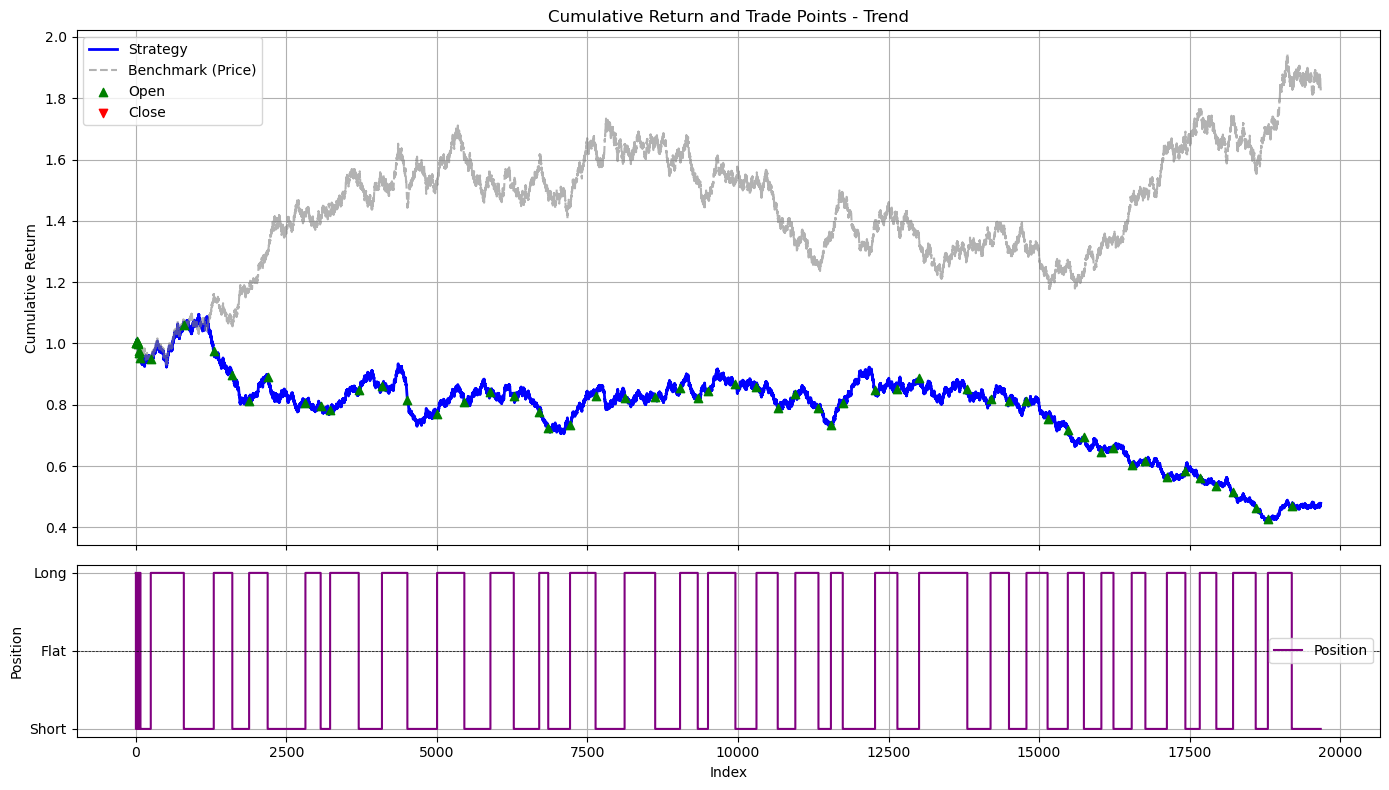

[固定阈值] upper=-0.0045, lower=-0.0045


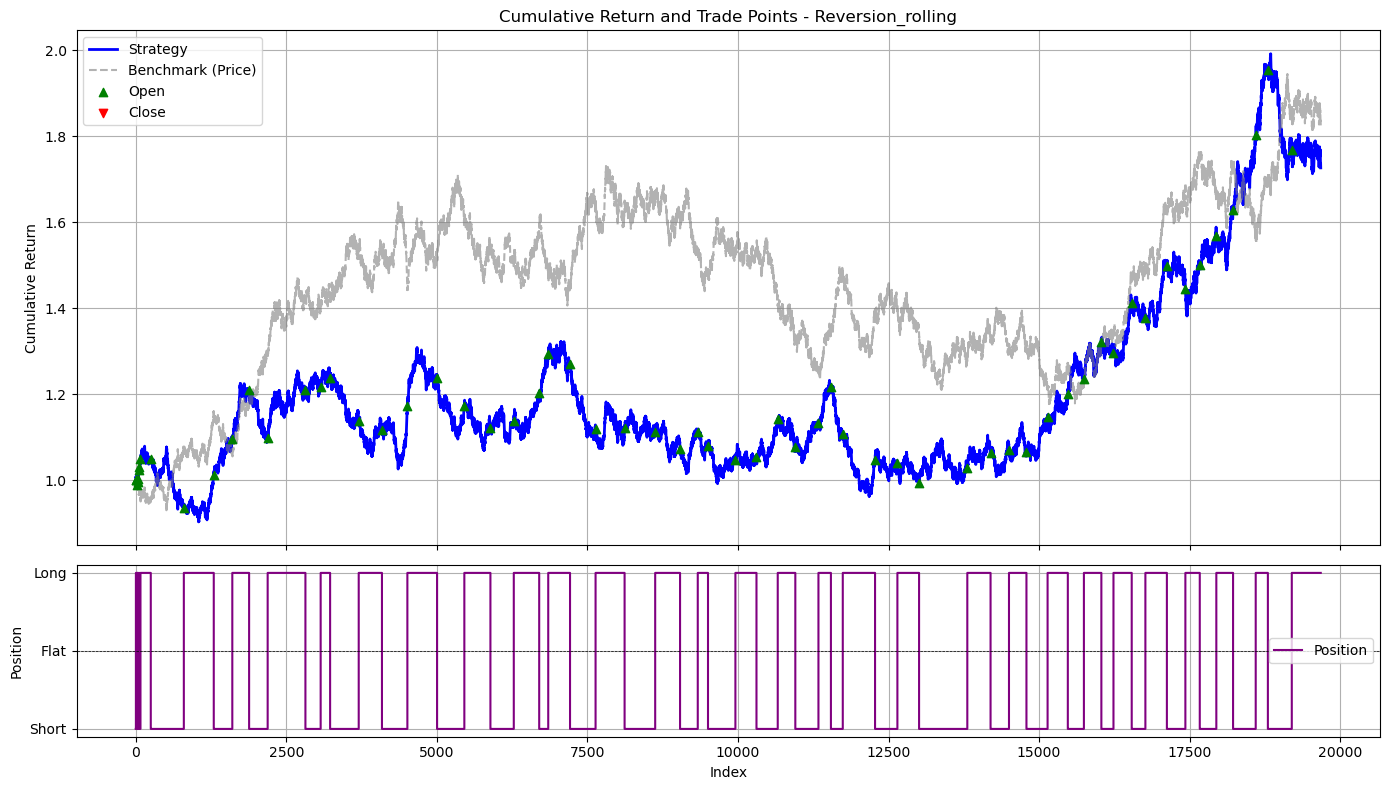

In [165]:
df_plot = plot_df.select(["px", "factor_mean"]).to_pandas()

# 趋势策略
trend_df_roll = strategy_with_position_logic(df_plot, mode="trend", rolling_quantile=False, window=2000)
plot_strategy(trend_df_roll, mode="trend")

# 回归策略
revert_df_roll = strategy_with_position_logic(df_plot, mode="mean_reversion", rolling_quantile=False, window=2000)
plot_strategy(revert_df_roll, mode="reversion_rolling")
